---
title: "{{< var pub.title >}} --"
date: 'October 20, 2025'
abstract-title: "Summary"
---

## Summary

We transform UMAP from a black box into a glass box. By fitting the mapping with a type of deep network, we calculate the contributions of input features to  every point as a linear weight, revealing the heretofore hidden logic of UMAP embeddings.

:::{.callout-note title="AI usage disclosure" collapse="true"}
This is a placeholder for the AI usage disclosure. Once all authors sign the AI code form on AirTable, SlackBot will message you an AI disclosure that you should place here.
:::

UMAP is a ubiquitous tool for low-dimensional visualization of high-dimensional datasets. UMAP learns a low-dimensional mapping from nearest-neighbor graph structures of datasets, often producing visually interpretable  clusters of data that match known labels (e.g., cell type). This is possible because the  mapping is highly nonlinear with respect to the input features values, giving it the expressive power needed to form distinct clusters. While the learned  relationship between the input features and the embedding positions is often useful, the same nonlinearity that enables clean clusters also makes it difficult to directly interpret the mapping in terms of the input features. 

Here, we show how to enable interpretation of the mapping through an alternative implementation of the parametric UMAP algorithm which learns the embedding with a deep network that is locally linear (but globally nonlinear) with respect to the input features. This “glass-box” approach provides a set of exact feature contributions as linear weights that determine the embedding of each data point. By computing the exact feature contribution for each point in a dataset, we can directly quantify which features are responsible for forming each cluster. We explore the feature contributions for a gene expression dataset from the glass-box augmentation of UMAP and compare them with features found by differential expression.


## Introduction

UMAP (Uniform Manifold Approximation and Projection) is a powerful tool for nonlinear dimensionality reduction. Despite some critical appraisals focused on the use of relative distances over the nonlinear embedding space to generate hypotheses, as well as the “black box” nature of the nonlinear mapping, UMAP remains popular in many fields. Here we present an augmentation to conventional UMAP analysis that generates exact feature attributions for each point in the dataset.

Principal components analysis (PCA) is another popular method for dimensionality reduction which finds an alternative linear representation of a dataset by determining a orthogonal directions of maximal variance. Since the principal components that can be used for dimensionality reduction are the linear weights on input feature, this approach was considered to be directly interpretable in feature space.

The recent popularity of the nonlinear UMAP embedding, which is excellent at forming distinctive clusters, came at the cost of interpretable embeddings. Nonlinear methods are generally thought to be black boxes, although there are a range of post-hoc feature attribution methods that provide some measure of interpretability (like differential expression applied for scRNAseq data). UMAP is ubiquitous because of its ability to successfully cluster classes for complex datasets in an unsupervised fashion, in spite of its black-box nature.

UMAP generates distinct clusters as a black box, while PCA provides (sometimes less-distinct) clusters for complex datasets, but also exact feature contributions. What if we could have the best of both approaches? A technique for interpreting nonlinear deep networks [Wang et al., 2016; Mohan et al., 2019] provides the key for bringing exact feature interpretability to UMAP. 


## Method

At a high level, UMAP emUMAP embeds high-dimensional data into low dimensions by building a nearest-neighbor graph in the original space and learning an embedding in the low-dimensional space that preserves the nearest-neighbor graph according to a loss function.

The extension to a “parametric” form of UMAP (McInnes, 2018 NC), where the low dimensional mapping is learned by a deep network, is a valuable generalization of the embedding approach where new data points can be embedded using the same function,which was not possible with the original version of UMAP. The parametric network is trained using the same loss function (TO DO: show loss function) as the non-parametric model, so this deep network function captures the same relationships as the original non-parametric implementation.

The deep network approach for parametric UMAP is conventionally considered to be somewhat opaque to feature attribution. However, by taking advantage of a growing body of work in this area, we can implement a deep network with a particular architecture that allows us to measure the exact contributions of each input feature.

In the “Extended Data Jacobian Matrix” [Wang et al., 2016] and “Bias-free deep networks…” [Mohan et al., 2019], it is shown that deep networks with zero bias linear layers and certain types of activation functions have exactly equivalent linear representations. Even though these networks are globally nonlinear, which is why deep networks can learn such complex mappings, they are also locally linear for a particular input. These networks fall into the category of homogeneous functions of order 1, which based on Euler’s theorem means a function $y(x)$ has an equivalent representation with the Jacobian $J$ which varies as a function of $x$:

$$y(x) = J(x) \cdot x$$

This is both linear and exact, although the Jacobian must be numerically computed for each input. Linear representations offer a straightforward approach to understanding what the network is doing. At the very least, they are more interpretable than locally nonlinear networks (which includes any deep network with nonzero bias terms in its linear layers).

It is straightforward to compute these linear feature contributions for every point in a dataset on a GPU. These types of deep networks for genomics data are locally linear, and from an interpretability perspective they are effectively globally linear. We easily can perform an exhaustive local analysis, where we compute the Jacobian (via autograd) for every point in a dataset. With globally linear systems, there is only one set of feature weights to analyze, but with locally linear systems, there are as many Jacobians (feature weights) as data points, this becomes an additional step in the analysis. 

The exactness of this Jacobian approach is the centerpiece of its appeal. This local analysis is similar to SHAP, LIME and GradCAM, but those are all approximations which could be completely incorrect for the actual nonlinear representation. The Jacobian of a zero-bias ReLU deep network simply weights each feature, quantifying how the globally nonlinear network uses it in the output.

In our case, we apply these deep networks with linear equivalents that exactly reconstruct the output to UMAP. In many papers, UMAP is presented as an interesting representation of data, but is not used much beyond that. In the conventional approach to defining cell type clusters in the embedding space, differential expression is run on various clusters to show what genes are differentially expressed on average (which is a completely different calculation than anything UMAP has done), and cell types are assigned based on those genes. In contrast, with fully interpretable “glass-box” networks, we can compute the exact contribution of each gene to the position of every single cell shown in the UMAP embedding space. Now, the exact gene feature contributions can be directly pulled from the nonlinear UMAP function, instead of from differential expression acting as a proxy for what UMAP learned. Additionally, the Jacobian approach works equally as well for image or protein embedding representations as scRNAseq data, where tools like differential expression are not available.

Beyond the feature attributions for each point, these can be aggregated over categories (like Leiden cluster or cell type) in order to generate hypotheses about the gene features connected to higher-level phenotypes represented in the dataset. This can be done in a straightforward manner by conditioning the feature attribution calculations on a given cell type (or Leiden cluster) and measuring summary statistics, like the mean or the SVD of the feature contributions.

The use of glass box deep networks for UMAP therefore provides clarity into what the embedding function has actually learned.


In [1]:
# | code-fold: true
# | output: false
#SingleCellPipeline class

import os
import sys
import subprocess
from collections import defaultdict
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
# from umap_pytorch import PUMAP

# import submodule
SUBMODULE_RELATIVE_PATH = 'external/umap_pytorch' 
project_root = os.getcwd()
submodule_root = os.path.join(project_root, SUBMODULE_RELATIVE_PATH)
if submodule_root not in sys.path:
    sys.path.insert(0, submodule_root) 
from umap_pytorch.main import PUMAP

# Plotting imports
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation
import matplotlib.ticker as ticker
from adjustText import adjust_text
import plotly.express as px
import plotly.graph_objects as go
import arcadia_pycolor as apc

# try:
#     from src.analysis.utils_jacobian import compute_gene_space_jacobian

class SingleCellPipeline:
    """
    Encapsulates the single-cell analysis workflow from preprocessing to
    parametric UMAP fitting, feature attribution, and visualization.
    """
    def __init__(self,
                 # Preprocessing & PCA
                 min_genes=100, min_cells=3, n_top_genes=2000, n_pcs=50,
                 # PUMAP params
                 n_neighbors=15, min_dist=0.3, repulsion_strength=3.0,
                 # Training params
                 n_fits=1, epochs=64, lr=1e-4, batch_size=2048, random_state=12):
        """Initializes the pipeline with all hyperparameters."""
        self.min_genes, self.min_cells, self.n_top_genes = min_genes, min_cells, n_top_genes
        self.n_pcs = n_pcs
        self.n_neighbors, self.min_dist, self.repulsion_strength = n_neighbors, min_dist, repulsion_strength
        self.n_fits, self.epochs, self.lr, self.batch_size, self.random_state = n_fits, epochs, lr, batch_size, random_state
        self.adata_, self.train_data_ = None, None
        self.models_, self.embeddings_ = [], []
        self.jacobians_, self.feature_contributions_ = [], []

    @staticmethod
    def download_bone_marrow_data(
        url="ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE194nnn/GSE194122/suppl/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz",
        filename="GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz"
    ) -> ad.AnnData:
        """
        Downloads, unzips, and loads the bone marrow dataset.

        Returns:
            ad.AnnData: The loaded AnnData object.
        """
        unzipped_filename = filename.replace(".gz", "")
        if not os.path.isfile(unzipped_filename):
            print(f"Downloading data from {url}...")
            if not os.path.isfile(filename):
                subprocess.run(["wget", url, "--no-verbose"])
            print("Unzipping data file...")
            subprocess.run(["gunzip", filename])
        
        print("Loading data...")
        return sc.read_h5ad(unzipped_filename)

    def _initial_preprocessing(self, adata):
        """
        Remove MT, RPS, RPL genes
        """
        adata.obs_names_make_unique(); adata.var_names_make_unique()
        adata.var["mt"] = adata.var_names.str.startswith("MT-")
        adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
        adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
        return adata

    def _run_quality_control(self, adata):
        sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
        return adata

    def _remove_mt_rps_genes(self, adata):
        genes_to_remove = adata.var["mt"] | adata.var["ribo"] 
        adata._inplace_subset_var(~genes_to_remove)
        return adata

    def _filter_and_detect_doublets(self, adata, run_scrublet=False):
        sc.pp.filter_cells(adata, min_genes=self.min_genes)
        sc.pp.filter_genes(adata, min_cells=self.min_cells)
        if run_scrublet: sc.pp.scrublet(adata, batch_key="sample")
        return adata

    def _normalize_and_select_features(self, adata):
        adata.layers["counts"] = adata.X.copy()
        sc.pp.normalize_total(adata); sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, n_top_genes=self.n_top_genes, batch_key="Samplename")
        return adata

    def _run_pca(self, adata):
        sc.tl.pca(adata, n_comps=self.n_pcs, use_highly_variable=True)
        return adata

    def fit(self, adata: ad.AnnData, 
            load_models: bool = False, 
            save_models: bool = True,
            model_path_pattern: str = "models/umap_{i}.pth"):
        """
        Runs the full preprocessing pipeline and either fits or loads the models.
        
        Args:
            adata (ad.AnnData): The raw AnnData object.
            load_models (bool): If True, skips training and loads pre-trained
                                models from `model_path_pattern`.
            save_models (bool): If True, saves the trained model weights to
                                `model_path_pattern` after fitting.
            model_path_pattern (str): A string pattern for the model file paths,
                                      e.g., "models/umap_{i}.pth", where {i}
                                      is the fit number.
        """
        import os
        print("--- Starting Preprocessing ---")
        self.adata_ = adata.copy()
        self.adata_ = self._initial_preprocessing(self.adata_)
        self.adata_ = self._run_quality_control(self.adata_)
        self.adata_ = self._remove_mt_rps_genes(self.adata_)
        self.adata_ = self._filter_and_detect_doublets(self.adata_)
        self.adata_ = self._normalize_and_select_features(self.adata_)
        self.adata_ = self._run_pca(self.adata_)
        self.train_data_ = torch.tensor(self.adata_.obsm['X_pca'], dtype=torch.float32)
        
        self.models_ = []
        self.embeddings_ = []
        
        # Determine device for loading models
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        for i in range(self.n_fits):
            print(f"\n--- Initializing Model {i+1}/{self.n_fits} ---")
            network = deepReLUNet(input_size=self.n_pcs, hidden_size=1024 + 128)
            if load_models:
                self.epochs=1
            pumap_model = PUMAP(encoder=network, n_neighbors=self.n_neighbors, min_dist=self.min_dist,
                                random_state=self.random_state + i,
                                lr=self.lr, epochs=self.epochs, batch_size=self.batch_size, num_workers=8, num_gpus=1)

            # Train or load
            model_file = model_path_pattern.format(i=i)
            
            if load_models:                                
                print(f"Loading pre-trained weights from: {model_file}")
                try:
                    pumap_model.device = device
                    pumap_model.encoder.to(device)
                    
                    pumap_model.fit(self.train_data_)
                    
                    pumap_model.encoder.load_state_dict(
                        torch.load(model_file, map_location=device)
                    )
                    pumap_model.encoder.eval() 
                
                except FileNotFoundError:
                    print(f"Error: Model file not found at {model_file}")
                    raise
                except Exception as e:
                    print(f"Error loading state dict for model {i}: {e}")
                    raise
            
            else:
                print(f"Fitting Model {i+1}/{self.n_fits} from scratch...")
                pumap_model.fit(self.train_data_)

                if save_models:
                    print(f"Saving trained weights to: {model_file}")
                    os.makedirs(os.path.dirname(model_file), exist_ok=True)
                    torch.save(pumap_model.encoder.state_dict(), model_file)
            
            print(f"Generating embedding for model {i+1}...")
            self.models_.append(pumap_model)
            embedding = pumap_model.transform(self.train_data_) 
            self.embeddings_.append(embedding)
            self.adata_.obsm[f'X_parametric_umap_{i}'] = embedding

        self.adata_.obsm['X_parametric_umap'] = self.embeddings_[0]
        
        if load_models:
            print(f"\n All {self.n_fits} models loaded and embeddings generated.")
        elif save_models:
            print(f"\n Fit complete. All {self.n_fits} models trained and saved.")
        else:
            print(f"\nFit complete. {self.n_fits} model(s) trained.")
            
        return self
    
    def plot_scanpy_umap(self):
        """
        Computes and plots the standard non-parametric UMAP using Scanpy.
        This is useful for comparing against the parametric results.
        """
        if self.adata_ is None:
            raise RuntimeError("The pipeline must be fitted before plotting.")

        print("--- Plotting Standard Scanpy UMAP ---")
        apc.mpl.setup()
        
        # Ensure neighbors are calculated
        if 'neighbors' not in self.adata_.uns:
            print("Calculating neighbors graph...")
            sc.pp.neighbors(self.adata_, n_neighbors=self.n_neighbors, use_rep='X_pca')
        
        # Compute standard UMAP
        sc.tl.umap(self.adata_, init_pos='random', random_state=13)

        # Order categories by frequency (most common first)
        category_order = self.adata_.obs['cell_type'].value_counts().index.tolist()
        
        # Get the 'cell_type' column from .obs
        cell_type_series = self.adata_.obs['cell_type']
        
        # Ensure the column is a pandas Series of string type for conversion
        if not isinstance(cell_type_series, pd.CategoricalDtype):
            cell_type_series = cell_type_series.astype('str')

        # Create a Pandas CategoricalDtype with the specified order
        cat_dtype = pd.CategoricalDtype(categories=category_order, ordered=True)
        
        # Apply the new ordered categorical type to the AnnData object's column
        self.adata_.obs['cell_type'] = cell_type_series.astype(cat_dtype)

        with mpl.rc_context({"figure.facecolor": apc.parchment, "axes.facecolor": apc.parchment}):
            ax = sc.pl.umap(
                self.adata_, color="cell_type", size=2,
                palette=list(apc.palettes.primary), show=False
            )
            ax.set_xlabel("UMAP 1", fontsize=10)
            ax.set_ylabel("UMAP 2", fontsize=10)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.set_title("Cell Type (Standard UMAP)")
            plt.show()

    def plot_parametric_umap(self, fit_index: int = -1, category_order: list = None):
        """
        Plots the UMAP embedding from a specific parametric model fit,
        with an optional custom order for the 'cell_type' categories.

        Args:
            fit_index (int): The index of the fitted model to visualize.
                            Defaults to the last one (-1).
            category_order (list, optional): A list of strings defining the 
                                            desired order of 'cell_type' 
                                            categories in the legend and plot.
                                            Defaults to None (uses existing order).
        """
        if not self.embeddings_:
            raise RuntimeError("The pipeline must be fitted before plotting.")
        
        # Resolve the index (e.g., -1 becomes the last index)
        resolved_index = fit_index if fit_index >= 0 else len(self.embeddings_) + fit_index
        print(f"--- Plotting Parametric UMAP (Fit {resolved_index}) ---")
        apc.mpl.setup()

        # Order categories by frequency (most common first)
        category_order = self.adata_.obs['cell_type'].value_counts().index.tolist()
        if category_order is not None:
            # Get the 'cell_type' column from .obs
            cell_type_series = self.adata_.obs['cell_type']
            
            # Ensure the column is a pandas Series of string type for conversion
            if not isinstance(cell_type_series, pd.CategoricalDtype):
                cell_type_series = cell_type_series.astype('str')

            # Create a Pandas CategoricalDtype with the specified order
            cat_dtype = pd.CategoricalDtype(categories=category_order, ordered=True)
            
            # Apply the new ordered categorical type to the AnnData object's column
            self.adata_.obs['cell_type'] = cell_type_series.astype(cat_dtype)

        # Temporarily assign the parametric embedding to the default UMAP slot for plotting
        self.adata_.obsm['X_umap'] = self.embeddings_[fit_index]

        with mpl.rc_context({"figure.facecolor": apc.parchment, "axes.facecolor": apc.parchment}):
            ax = sc.pl.umap(
                self.adata_, use_raw=False, color='cell_type', size=2,
                palette=list(apc.palettes.primary),
                show=False
            )
            ax.set_xlabel("UMAP 1", fontsize=10)
            ax.set_ylabel("UMAP 2", fontsize=10)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.set_title(f"Cell Type (Parametric UMAP Fit {resolved_index})")
            plt.show()
            
    def compute_feature_contributions(self, jacobian_batch_size: int = 40):
        """
        Orchestrates the computation of the Jacobian for all fitted models.

        This method iterates through each trained model and calls a private helper
        to perform the actual Jacobian calculation, then stores the results.

        Args:
            jacobian_batch_size (int): The batch size for Jacobian calculation to
                                       manage memory usage.
        """
        if not self.models_:
            raise RuntimeError("The model must be fitted before computing contributions.")
        
        self.feature_contributions_ = []
        self.jacobians_ = []

        for i, model in enumerate(self.models_):
            print(f"--- Computing Jacobian for Model {i+1}/{self.n_fits} ---")
            
            # Call the private helper to do the heavy lifting
            jacobxall, jacobian_pca = self._compute_jacobian_for_model(
                model.encoder, batch_size=jacobian_batch_size
            )
            
            # Store the results
            self.feature_contributions_.append(jacobxall)
            self.jacobians_.append(jacobian_pca)

        print("\nJacobian computation complete for all models.")
        return self

    def _compute_jacobian_for_model(self, encoder, batch_size: int = 40):
        """
        Computes a model's Jacobian and projects it to the original gene space.
        (Private helper method).

        Args:
            encoder: The trained PyTorch model encoder.
            batch_size: The batch size for Jacobian calculation.

        Returns:
            A tuple containing:
            - np.ndarray: The Jacobian projected into gene space (feature contributions).
            - list: The raw Jacobians in PCA space.
        """
        encoder.eval()
        
        # 1. Prepare data
        adfmz = self.adata_.to_df().values - self.adata_.to_df().mean(axis=0).values
        num_samples = self.train_data_.shape[0]

        # 2. Compute Jacobian in batches (in PCA space)
        jacobians_pca_list = []
        for i in range(0, num_samples, batch_size):
            data_batch = self.train_data_[i:i + batch_size, :]
            
            # The core PyTorch Jacobian calculation
            jac_batch = torch.autograd.functional.jacobian(
                encoder, data_batch, vectorize=True, strategy="reverse-mode"
            )
            
            # The output of vectorize=True is diagonalized, so we extract the diagonal
            # to get the Jacobian for each sample in the batch.
            # Shape becomes (batch_size, n_outputs, n_inputs)
            jac_batch_unfused = torch.einsum('bibj->bij', jac_batch)
            jacobians_pca_list.append(jac_batch_unfused.detach().cpu())

        jacobians_pca_tensor = torch.cat(jacobians_pca_list, dim=0)

        # 3. Project Jacobian from PCA space back to gene space
        pcs = self.adata_.varm["PCs"] # Shape: (n_genes, n_pcs)
        
        # Einstein summation for batched matrix multiplication:
        # J_gene[i, emb, gene] = J_pca[i, emb, pc] * PCs[gene, pc]
        # This is equivalent to (J_pca @ PCs.T) for each sample i
        gene_space_jacobian = torch.einsum('bij,kj->bik', jacobians_pca_tensor, torch.tensor(pcs, dtype=torch.float32))

        # 4. Weight by each cell's mean-centered gene expression
        # This gives the final "feature contribution" or "attribution"
        feature_contributions = gene_space_jacobian.numpy() * adfmz[:, np.newaxis, :]
        
        # For memory efficiency, convert to float16
        feature_contributions = feature_contributions.astype('float16')
        
        return feature_contributions, jacobians_pca_tensor
    
    ## --------------------------------
    ## --- Analysis & Plotting Methods ---
    ## --------------------------------
    
    def validate_jacobian(
        self, 
        fit_index=0, 
        summary_plot_file="analysis_summary_plot_data.npz"
    ):
        """
        Plots the UMAP embedding vs. its reconstruction from the Jacobian
        to validate the accuracy of the feature attribution calculation.
        
        Tries to load data from the summary file. If it doesn't exist,
        it generates the data on-the-fly from the pipeline's internal state.
        
        Args:
            fit_index (int): The index of the fitted model to visualize
                             (only used if data is generated on-the-fly).
            summary_plot_file (str): Path to the .npz file containing
                                     pre-computed analysis data.
        """
        import os

        can_load_from_file = (summary_plot_file and os.path.exists(summary_plot_file))

        if can_load_from_file:
            print(f"--- Loading validation data from {summary_plot_file} ---")
            if fit_index != 0:
                print(f"Warning: Loading from file. File only contains data for "
                      f"fit_index 0. Ignoring requested fit_index={fit_index}.")
            
            with np.load(summary_plot_file, allow_pickle=True) as data:
                if 'embedding' not in data or 'jacobian_reconstruction' not in data:
                    raise KeyError(
                        f"File {summary_plot_file} is missing required data "
                        "('embedding' or 'jacobian_reconstruction')."
                    )
                embedding = data['embedding']
                reconstruction = data['jacobian_reconstruction']

        else:
            print(f"--- Summary file not found. Generating validation data "
                  f"for fit {fit_index} on-the-fly... ---")
            
            # Check for all required live data
            if (not self.jacobians_ or 
                not self.embeddings_ or 
                self.train_data_ is None):
                raise RuntimeError(
                    "Must run fit() and compute_feature_contributions() first "
                    "to generate data on-the-fly."
                )

            # Check if index is valid for live data
            if (fit_index >= len(self.jacobians_) or 
                fit_index >= len(self.embeddings_)):
                raise IndexError(
                    f"fit_index {fit_index} is out of bounds for "
                    "on-the-fly data generation."
                )

            jacobian = self.jacobians_[fit_index]
            embedding = self.embeddings_[fit_index]
            
            # Calculate reconstruction from Jacobian
            pca_data = self.train_data_.squeeze().detach().cpu().numpy()
            reconstruction = np.einsum('ijk,ik->ij', jacobian.numpy(), pca_data)
        
        with mpl.rc_context({"figure.facecolor": "white", "axes.facecolor": "white"}):
            plt.figure(figsize=(6, 6))
            # Plot UMAP dim 0 vs. Reconstruction dim 0
            plt.scatter(embedding[:, 0], reconstruction[:, 0], alpha=0.5, label="Dim 0")
            # Plot dim 1
            # plt.scatter(embedding[:, 1], reconstruction[:, 1], alpha=0.5, label="Dim 1")
            
            # Determine axis limits dynamically for a good fit
            min_val = min(embedding[:, 0].min(), reconstruction[:, 0].min()) - 1
            max_val = max(embedding[:, 0].max(), reconstruction[:, 0].max()) + 1
            
            plt.plot([min_val, max_val], [min_val, max_val], 'r', linewidth=2, label="Identity (exact)")
            plt.xlabel('UMAP Embedding (Dim 0)')#, fontsize=12)
            plt.ylabel('Jacobian Reconstruction (Dim 0)')#, fontsize=12)
            plt.title('Jacobian Reconstruction Accuracy')#, fontsize=14)
            plt.legend()            
            plt.axis('square')
            plt.xlim(min_val, max_val)
            plt.ylim(min_val, max_val)
            plt.show()


    def _prepare_plotly_df(self, fit_index=0, top_n_genes=8):
        """Prepares a DataFrame for interactive plotting."""
        if not self.feature_contributions_:
            raise RuntimeError("Feature contributions must be computed first.")

        embedding = self.embeddings_[fit_index]
        jacobxall = self.feature_contributions_[fit_index]
        
        df = pd.DataFrame(embedding, columns=['UMAP 1', 'UMAP 2'])
        df['Cell Type'] = self.adata_.obs.cell_type.values

        # Calculate squared distance and find top contributing genes
        gene_dist_sq = jacobxall[:, 0, :]**2 + jacobxall[:, 1, :]**2
        genes = self.adata_.var.index.values
        
        top_gene_indices = np.argsort(gene_dist_sq, axis=1)[:, ::-1][:, :top_n_genes]
        
        for i in range(top_n_genes):
            df[f'gene_{i}'] = genes[top_gene_indices[:, i]]
            
        return df

    def plot_interactive(
        self, 
        color_by='cell_type', 
        top_n_to_show=16, 
        show_centroids=False, 
        fit_index=0,
        summary_file="analysis_summary_interactive.csv"
    ):
        """
        Generates an interactive Plotly UMAP embedding.
        
        Tries to load data from `summary_file`. If the file doesn't exist,
        it generates the data on-the-fly and saves it to the file path
        to create a cache for future use.
        """
        import os
        apc.plotly.setup()

        if summary_file and os.path.exists(summary_file):
            print(f"--- Loading interactive data from {summary_file} ---")
            df = pd.read_csv(summary_file)
        else:
            print(f"--- Summary file not found. Generating data on-the-fly... ---")
            if not self.feature_contributions_:
                raise RuntimeError("Must run compute_feature_contributions() first to generate data.")
            
            df = self._prepare_plotly_df(fit_index=fit_index)
            
            if summary_file:
                print(f"--- Saving newly generated data to {summary_file} ---")
                df.to_csv(summary_file, index=False)

        hover_data = ['gene_0', 'gene_1', 'gene_2', 'Cell Type']
        
        if color_by == 'cell_type':
            fig = px.scatter(
                df, x='UMAP 1', y='UMAP 2', color='Cell Type',
                title='Bone Marrow Gene Expression: Cell Types',
                hover_data={k: True for k in hover_data if k != 'Cell Type'},
                category_orders={'Cell Type': df['Cell Type'].astype('category').value_counts().index},
                color_discrete_sequence=(apc.palettes.primary + apc.palettes.secondary)
            )
            grouping_col, data_for_centroids = 'Cell Type', df
        
        elif color_by == 'top_gene':
            df['gene_0'] = df['gene_0'].astype(str)
            top_genes = df['gene_0'].value_counts().nlargest(top_n_to_show).index
            df_filtered = df[df['gene_0'].isin(top_genes)]
            percent_shown = len(df_filtered) / len(df)
            title = f'Bone Marrow: Top Gene Contributors ({percent_shown:.1%} of cells shown)'
            fig = px.scatter(
                df_filtered, x='UMAP 1', y='UMAP 2', color='gene_0',
                title=title, hover_data=hover_data,
                category_orders={'gene_0': top_genes},
                color_discrete_sequence=(apc.palettes.secondary + apc.palettes.primary)
            )
            grouping_col, data_for_centroids = 'gene_0', df_filtered
        
        else:
            raise ValueError("color_by must be 'cell_type' or 'top_gene'")

        if show_centroids:
            centroids = data_for_centroids.groupby(grouping_col)[['UMAP 1', 'UMAP 2']].mean()
            for label, center in centroids.iterrows():
                fig.add_annotation(
                    x=center['UMAP 1'], y=center['UMAP 2'], text=f"<b>{label}</b>",
                    showarrow=False, font=dict(size=16, color='black'),
                    align='center', bgcolor='rgba(255, 255, 255, 0.5)', borderpad=4
                )
                
        fig.update_traces(marker_size=6)
        # fig.update_layout(width=900, height=800, autosize=False, legend={'itemsizing': 'constant'})
        fig.update_layout(
            # width=900, 
            # height=800, 
            autosize=True, 
            legend={
                'itemsizing': 'constant',
                'y': 1,                     # Align legend to the top of the plot area
                'x': 1.02,                  # Position legend just outside the right edge (1.0)
                'yanchor': 'top',           # Anchor the legend's top edge
                'xanchor': 'left'           # Anchor the legend's left edge
            }
        )
        apc.plotly.style_plot(fig, monospaced_axes="all")
        fig.show()

    def plot_feature_importance_by_cell_type(

        self, 
        n_features_bars=12, 
        n_features_vectors=5,
        fit_index=0, 
        cell_type_plot=None,
        summary_stats_file="analysis_summary_stats.csv",
        summary_plot_file="analysis_summary_plot_data.npz"
    ):
        """
        Analyzes and visualizes feature contributions for each cell type.
        
        Tries to load data from summary files. If they don't exist,
        it generates the data on-the-fly from the pipeline's internal state.
        """
        import os
        
        can_load_from_file = (
            summary_stats_file and os.path.exists(summary_stats_file) and
            summary_plot_file and os.path.exists(summary_plot_file)
        )
        
        if can_load_from_file:
            print(f"--- Loading data from {summary_stats_file} and {summary_plot_file} ---")
            summary_df = pd.read_csv(summary_stats_file)
            with np.load(summary_plot_file, allow_pickle=True) as data:
                embedding = data['embedding']
                cell_types_array = data['cell_types']
                mean_jacobian_vectors = data['mean_jacobian_vectors'].item()
                gene_names_original_order = data['gene_names']
            
            all_cell_types = pd.Series(cell_types_array).value_counts().index
            
        else:
            print("--- Summary files not found. Generating data on-the-fly... ---")
            if not self.feature_contributions_:
                raise RuntimeError("Must run compute_feature_contributions() first to generate data.")
            
            all_run_jacobians = np.array(self.feature_contributions_)
            embedding = self.embeddings_[fit_index]
            cell_types_array = self.adata_.obs.cell_type.values
            all_cell_types = self.adata_.obs["cell_type"].value_counts().index
            n_runs = all_run_jacobians.shape[0]
            gene_names_original_order = self.adata_.var_names.values 

            # Re-calculate stats on the fly
            summary_dfs = []
            mean_jacobian_vectors = {}
            for cell_type in all_cell_types:
                is_cell_type_mask = (self.adata_.obs["cell_type"] == cell_type)
                jacobians_for_cell_type = all_run_jacobians[:, is_cell_type_mask, :, :]
                magnitudes = np.linalg.norm(jacobians_for_cell_type, axis=2)
                
                run_mean_contributions = []
                for run_idx in range(n_runs):
                    run_mags = magnitudes[run_idx, :, :]
                    norm_factor = np.mean(np.sum(run_mags, axis=1))
                    normalized_mags = (run_mags.T / (norm_factor + 1e-6)).T
                    run_mean_contributions.append(np.mean(normalized_mags, axis=0))
                
                mean_contributions = np.mean(np.array(run_mean_contributions), axis=0)
                sem_contributions = np.std(np.array(run_mean_contributions), axis=0) / np.sqrt(n_runs)
                
                df = pd.DataFrame({
                    'gene': gene_names_original_order, 'mean_contribution': mean_contributions,
                    'sem_contribution': sem_contributions, 'cell_type': cell_type
                })
                summary_dfs.append(df)
                mean_jacobian_vectors[cell_type] = np.mean(all_run_jacobians[fit_index, is_cell_type_mask, :, :], axis=0)

            summary_df = pd.concat(summary_dfs, ignore_index=True)

        if cell_type_plot is None:
            cell_types_to_plot = all_cell_types[:12]
        else:
            cell_types_to_plot = [all_cell_types[i] for i in cell_type_plot]
        
        cmap = (apc.palettes.primary + apc.palettes.secondary).to_mpl_cmap()
        category_colors = [cmap(i / len(all_cell_types)) for i in range(len(all_cell_types))]
        color_map = {name: color for name, color in zip(all_cell_types, category_colors)}
        point_colors = np.array([color_map.get(ct, 'gray') for ct in cell_types_array])

        # Create a mapping from gene name to its index in the original vector array
        gene_to_original_index = {gene: i for i, gene in enumerate(gene_names_original_order)}

        with mpl.rc_context({"figure.facecolor": apc.parchment, "axes.facecolor": apc.parchment}):
            for cell_type in cell_types_to_plot:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), subplot_kw=dict(box_aspect=1))
                is_cell_type_mask = (cell_types_array == cell_type)

                ax1.scatter(embedding[:, 0], embedding[:, 1], c=point_colors, s=2, alpha=0.1)
                ax1.scatter(embedding[is_cell_type_mask, 0], embedding[is_cell_type_mask, 1], c=[color_map.get(cell_type, 'gray')], s=14, marker="o", label=cell_type)
                # ax1.set_title(f"{cell_type}"); ax1.set_xlabel("UMAP 1"); ax1.set_ylabel("UMAP 2")
                ax1.grid(False); ax1.legend(); ax1.spines[['right', 'top']].set_visible(False)

                cell_type_df = summary_df[summary_df['cell_type'] == cell_type].sort_values('mean_contribution', ascending=False)
                
                if cell_type_df.empty:
                    print(f"Skipping plot for {cell_type}: no data found in summary.")
                    plt.close(fig)
                    continue

                top_bar_indices = cell_type_df.index[:n_features_bars]
                top_vector_indices = cell_type_df.index[:n_features_vectors]
                
                vectors_for_cell = mean_jacobian_vectors.get(cell_type)
                if vectors_for_cell is None:
                    print(f"Skipping vectors for {cell_type}: no mean_jacobian_vectors found.")
                    continue
                
                cluster_centroid = np.mean(embedding[is_cell_type_mask], axis=0)
                
                top_gene_names = cell_type_df.loc[top_vector_indices, 'gene']
                top_gene_original_indices = [gene_to_original_index[gene] for gene in top_gene_names if gene in gene_to_original_index]

                if top_gene_original_indices:
                    max_vector_mag = np.max(np.linalg.norm(vectors_for_cell[:, top_gene_original_indices], axis=0))
                    scale_factor = (np.linalg.norm(cluster_centroid) / (max_vector_mag + 1e-6)) * 0.8
                else:
                    scale_factor = 1.0

                texts = []
                for gene_idx in top_vector_indices:
                    gene_name = cell_type_df.loc[gene_idx, 'gene']
                    gene_original_index = gene_to_original_index.get(gene_name)
                    
                    if gene_original_index is not None:
                        vec = vectors_for_cell[:, gene_original_index] * scale_factor
                        ax1.arrow(0, 0, vec[0], vec[1], width=0.15, color='k', head_width=0.5, zorder=3)
                        texts.append(ax1.text(vec[0], vec[1], gene_name, fontsize=12,
                                            bbox=dict(boxstyle="round,pad=0.2", fc=apc.parchment, ec="none", alpha=0.8)))
                
                if texts: 
                    adjust_text(texts, ax=ax1, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

                top_genes = cell_type_df.loc[top_bar_indices, 'gene'][::-1]
                top_means = cell_type_df.loc[top_bar_indices, 'mean_contribution'][::-1]
                top_sems = cell_type_df.loc[top_bar_indices, 'sem_contribution'][::-1]

                bars = ax2.barh(top_genes, top_means, xerr=top_sems, capsize=3, color=color_map.get(cell_type, 'gray'))
                ax2.bar_label(bars, labels=[f'{g}' for g in top_genes], padding=5)
                ax2.tick_params(axis='y', left=False, labelleft=False); ax2.set_xlabel("Normalized feature contribution (mean ± SEM)")
                # ax2.set_title(f"Top gene contributions for '{cell_type}'"); ax2.spines[['right', 'top']].set_visible(False)
                
                # formatter = ticker.StrMethodFormatter('{x:.4f}')
                # ax2.xaxis.set_major_formatter(formatter)
                plt.tight_layout(); plt.show()

    def compare_with_differential_expression(
        self, 
        n_top_genes=2, 
        summary_stats_file="analysis_summary_stats.csv",
        summary_plot_file="analysis_summary_plot_data.npz" 
    ):
        """
        Compares Jacobian features with differential expression via dot plots.
        
        Tries to load Jacobian stats and magnitudes from summary files.
        If not found, it computes them on-the-fly.
        """
        import os
        layer_to_use = None
        
        can_load_from_file = (
            summary_stats_file and os.path.exists(summary_stats_file) and
            summary_plot_file and os.path.exists(summary_plot_file)
        )
        
        if can_load_from_file:
            print(f"--- Loading Jacobian stats from {summary_stats_file} ---")
            summary_df = pd.read_csv(summary_stats_file)
            
            jacobian_dict = {}
            for cell_type in self.adata_.obs['cell_type'].cat.categories:
                if cell_type in summary_df['cell_type'].values:
                    top_genes = summary_df[summary_df['cell_type'] == cell_type].sort_values(
                        'mean_contribution', ascending=False
                    )['gene'].values[:n_top_genes]
                    jacobian_dict[cell_type] = list(top_genes)
            
            print(f"--- Loading Jacobian magnitudes from {summary_plot_file} ---")
            with np.load(summary_plot_file, allow_pickle=True) as data:
                if 'jacobian_magnitude' not in data or 'gene_names' not in data:
                    print("Warning: 'jacobian_magnitude' or 'gene_names' not found in summary file.")
                else:
                    loaded_magnitude = data['jacobian_magnitude']
                    loaded_genes = data['gene_names'] # Gene names from the NPZ file
                    
                    # Check if the shape and gene names match the current adata
                    if (self.adata_.shape == loaded_magnitude.shape and 
                        np.all(self.adata_.var_names == loaded_genes)):
                        
                        print("Adata and summary file genes match. Assigning layer directly.")
                        self.adata_.layers['jacobian_magnitude'] = loaded_magnitude
                    else:
                        # --- THIS IS THE FIX ---
                        print(f"Adata/summary gene mismatch. Re-aligning layer...")
                        print(f"  Adata shape: {self.adata_.shape}")
                        print(f"  Layer shape: {loaded_magnitude.shape}")

                        # Create a mapping from the loaded gene names to their data index
                        gene_to_npz_index = {gene: i for i, gene in enumerate(loaded_genes)}
                        
                        # Create a new, empty layer with the shape of the current adata
                        new_layer = np.zeros(self.adata_.shape, dtype=loaded_magnitude.dtype)
                        
                        # Fill the new layer with data from the loaded file
                        genes_found = 0
                        for i, gene in enumerate(self.adata_.var_names):
                            if gene in gene_to_npz_index:
                                new_layer[:, i] = loaded_magnitude[:, gene_to_npz_index[gene]]
                                genes_found += 1
                        
                        print(f"  Aligned {genes_found} genes from summary file into new layer.")
                        if genes_found == 0:
                            print("Warning: No matching genes found. Layer will be empty.")

                        self.adata_.layers['jacobian_magnitude'] = new_layer
                    
                    layer_to_use = 'jacobian_magnitude'
                
        else:
            print("--- Summary files not found. Generating Jacobian stats on-the-fly... ---")
            # ... (on-the-fly logic remains unchanged) ...
            if not self.feature_contributions_:
                raise RuntimeError("Must run compute_feature_contributions() first to generate stats.")
            
            all_run_jacobians = np.array(self.feature_contributions_)
            n_runs = all_run_jacobians.shape[0]
            mean_contributions_dict = {}
            for cell_type in self.adata_.obs["cell_type"].cat.categories:
                is_cell_type_mask = (self.adata_.obs["cell_type"] == cell_type)
                magnitudes = np.linalg.norm(all_run_jacobians[:, is_cell_type_mask, :, :], axis=2)
                run_means = [np.mean(((m.T / (np.mean(np.sum(m, axis=1)) + 1e-6))).T, axis=0) for m in magnitudes]
                mean_contributions_dict[cell_type] = np.mean(run_means, axis=0)
            
            genes = self.adata_.var_names
            jacobian_dict = {
                ct: [genes[i] for i in np.argsort(mean_contributions_dict[ct])[::-1][:n_top_genes]]
                for ct in self.adata_.obs['cell_type'].cat.categories
            }
            jacobxall_first_run = self.feature_contributions_[0]
            self.adata_.layers['jacobian_magnitude'] = np.linalg.norm(jacobxall_first_run, axis=1)
            layer_to_use = 'jacobian_magnitude'

        print("--- Running differential expression analysis ---")
        sc.tl.rank_genes_groups(self.adata_, groupby="cell_type", method="wilcoxon", n_genes=n_top_genes)

        de_dict = {
            name: list(self.adata_.uns['rank_genes_groups']['names'][name])
            for name in self.adata_.uns['rank_genes_groups']['names'].dtype.names
        }

        combined_genes = defaultdict(list)
        seen_genes = set()
        for d in (de_dict, jacobian_dict):
            for key, value in d.items():
                for gene in value:
                    if gene not in seen_genes:
                        combined_genes[key].append(gene)
                        seen_genes.add(gene)
        
        print("--- Generating comparison dot plots ---")
        with mpl.rc_context({"figure.facecolor": apc.parchment, "axes.facecolor": apc.parchment}):
            # Plot 1: Differential Expression

            # sc.tl.dendrogram(self.adata_, var_names=combined_genes, groupby='cell_type')
            ax1 = sc.pl.rank_genes_groups_dotplot(
                self.adata_, var_names=combined_genes, groupby='cell_type', 
                standard_scale="var", show=False
            )
            # ax1['mainplot_ax'].set_title("Differential expression (Combined DE + Jacobian Genes)", y=1.9, fontsize=14)
            plt.show()

            # Plot 2: Jacobian Feature Importance
            if layer_to_use:
                # sc.tl.dendrogram(self.adata_, var_names=combined_genes, groupby='cell_type',layer=layer_to_use)
                ax2 = sc.pl.rank_genes_groups_dotplot(
                    self.adata_, var_names=combined_genes, groupby='cell_type', 
                    layer=layer_to_use, standard_scale="var", show=False
                )
                # ax2['mainplot_ax'].set_title("Jacobian feature importance", y=1.9, fontsize=14)
                plt.show()
            else:
                print(f"Warning: Could not plot Jacobian dot plot. 'jacobian_magnitude' data was not found.")

    def save_analysis_summary(self, basename="analysis_summary"):
        """
        Saves all necessary data for offline plotting and analysis.
        
        This creates three files:
        1.  `{basename}_stats.csv`: Mean/SEM of contributions for all genes.
        2.  `{basename}_plot_data.npz`: UMAP embedding, cell type labels,
            mean Jacobian vectors, per-cell Jacobian magnitudes,
            original gene names, and **Jacobian reconstruction values**.
        3.  `{basename}_interactive.csv`: Pre-computed data for the
            interactive Plotly chart.
            
        Args:
            basename (str): The prefix for the three output files.
        """
        # Updated check to include data needed for reconstruction
        if (not self.feature_contributions_ or 
            not self.embeddings_ or 
            not self.jacobians_ or 
            self.train_data_ is None):
            raise RuntimeError("Must run fit() and compute_feature_contributions() first.")
            
        print(f"--- Saving analysis summary to files starting with '{basename}' ---")

        print("Calculating and saving population-level statistics...")
        all_run_jacobians = np.array(self.feature_contributions_)
        n_runs = all_run_jacobians.shape[0]
        all_cell_types = self.adata_.obs["cell_type"].cat.categories
        
        summary_dfs = []
        for cell_type in all_cell_types:
            is_cell_type_mask = (self.adata_.obs["cell_type"] == cell_type)
            magnitudes = np.linalg.norm(all_run_jacobians[:, is_cell_type_mask, :, :], axis=2)
            
            run_mean_contributions = []
            for run_idx in range(n_runs):
                run_mags = magnitudes[run_idx, :, :]
                norm_factor = np.mean(np.sum(run_mags, axis=1))
                normalized_mags = (run_mags.T / (norm_factor + 1e-6)).T
                run_mean_contributions.append(np.mean(normalized_mags, axis=0))
            
            mean_contributions = np.mean(np.array(run_mean_contributions), axis=0)
            sem_contributions = np.std(np.array(run_mean_contributions), axis=0) / np.sqrt(n_runs)

            df = pd.DataFrame({
                'gene': self.adata_.var_names, 'mean_contribution': mean_contributions,
                'sem_contribution': sem_contributions, 'cell_type': cell_type
            })
            summary_dfs.append(df)
            
        final_summary = pd.concat(summary_dfs, ignore_index=True)
        stats_filename = f"{basename}_stats.csv"
        final_summary.to_csv(stats_filename, index=False)
        print(f"Saved stats to {stats_filename}")

        print("Saving UMAP embedding, labels, and vector data...")
        mean_vector_dict = {}
        for cell_type in all_cell_types:
            is_cell_type_mask = (self.adata_.obs["cell_type"] == cell_type)
            mean_vector_dict[cell_type] = np.mean(self.feature_contributions_[0][is_cell_type_mask], axis=0)
            
        jacobxall_first_run = self.feature_contributions_[0]
        jacobian_magnitude = np.linalg.norm(jacobxall_first_run, axis=1)

        print("Calculating Jacobian reconstruction for validation...")
        jacobian_0 = self.jacobians_[0]
        pca_data_0 = self.train_data_.squeeze().detach().cpu().numpy()
        reconstruction_0 = np.einsum('ijk,ik->ij', jacobian_0.numpy(), pca_data_0)

        plot_data_filename = f"{basename}_plot_data.npz"
        np.savez_compressed(
            plot_data_filename,
            embedding=self.embeddings_[0],
            cell_types=self.adata_.obs.cell_type.values,
            mean_jacobian_vectors=mean_vector_dict,
            jacobian_magnitude=jacobian_magnitude,
            gene_names=self.adata_.var_names.values,
            jacobian_reconstruction=reconstruction_0  
        )
        print(f"Saved plot data to {plot_data_filename}")

        print("Saving data for interactive plot...")
        interactive_df = self._prepare_plotly_df(fit_index=0)
        interactive_filename = f"{basename}_interactive.csv"
        interactive_df.to_csv(interactive_filename, index=False)
        print(f"Saved interactive data to {interactive_filename}")
        print("\n--- Summary export complete! ---")
    

########################            
# PyTorch MLP for UMAP    
########################
from torch import nn
class LayerNormDetached(nn.Module):
    '''
    A LayerNorm implementation where the variance calculation is detached from the
    computation graph during evaluation, potentially stabilizing training.
    '''
    def __init__(self, emb_dim: int):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(emb_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''Forward pass for LayerNormDetached.'''
        mean = x.mean(dim=-1, keepdim=True)
        # Detach variance calculation during evaluation
        if not self.training:
            var = x.clone().detach().var(dim=-1, keepdim=True, unbiased=False)
        else:
            var = x.var(dim=-1, keepdim=True, unbiased=False)

        norm_x = (x - mean) / torch.sqrt(var + 1e-12) # Added epsilon for stability
        return self.scale * norm_x

class deepReLUNet(nn.Module):
    """
    A deep neural network using PReLU activation and LayerNormDetached.
    """
    def __init__(self, input_size: int = 50, hidden_size: int = 256, output_size: int = 2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size, bias=False), nn.PReLU(), LayerNormDetached(hidden_size),
            nn.Linear(hidden_size, hidden_size, bias=False), nn.PReLU(), LayerNormDetached(hidden_size),
            nn.Linear(hidden_size, hidden_size, bias=False), nn.PReLU(), LayerNormDetached(hidden_size),
            nn.Linear(hidden_size, hidden_size, bias=False), nn.PReLU(), LayerNormDetached(hidden_size),
            nn.Linear(hidden_size, hidden_size, bias=False), nn.PReLU(),
            nn.Linear(hidden_size, output_size, bias=False)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the PReLU network."""
        return self.model(x)
    

## Loading the data and tools

For an example dataset, we will use the human bone marrow gene expression data of Luecken, et. al., (2021), which is the example dataset now included in ScanPy. 

Luecken, M. D., Burkhardt, D. B., Cannoodt, R., Lance, C., Agrawal, A., Aliee, H., ... & Bloom, J. M. (2021, August). A sandbox for prediction and integration of DNA, RNA, and proteins in single cells. In Thirty-fifth conference on neural information processing systems datasets and benchmarks track (Round 2).

The preprocessing pipeline follows the standard procedure for the dataset in [the ScanPy clustering tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html). We take the extra step of filtering out the less common cell types to simplify visualizations and keep only the top 12.

In [2]:
# | code-fold: true
# | output-fold: true
# | output-summary: "Click to view results"
# The Complete Workflow using the FINAL SingleCellPipeline Class

# 1. Download and prepare the data (same as before)
# 1. Download and prepare the data
adata_raw = SingleCellPipeline.download_bone_marrow_data()

# --- FIX: Make gene names unique BEFORE slicing ---
# This will append '-1', '-2', etc. to any duplicate gene names.
adata_raw.var_names_make_unique()

# 2. Now, you can safely slice the data
adata_subset1 = adata_raw[adata_raw.obs['Samplename'] == 'site1_donor1_cite', :].copy()
adata_subset3 = adata_raw[adata_raw.obs['Samplename'] == 'site1_donor3_cite', :].copy()

# 3. Concatenation will now work without error
adata_filtered = ad.concat([adata_subset1, adata_subset3], label="donors")

# It's also good practice to make cell names unique after concatenation
adata_filtered.obs_names_make_unique()

top_cell_types = adata_filtered.obs.cell_type.value_counts().nlargest(12).index
adata_final = adata_filtered[adata_filtered.obs.cell_type.isin(top_cell_types)].copy()

print("Data sliced and concatenated successfully!")

Loading data...


/home/ubuntu/miniconda3/envs/glass-box-umap/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning:

Variable names are not unique. To make them unique, call `.var_names_make_unique`.



Data sliced and concatenated successfully!


We will also load a set of tools including the "UMAP PyTorch" toolbox in addition to ScanPy, and define a custom PyTorch network to learn an embedding.

We carry out several independent UMAP fits to the data starting at different random initializations in order to generate error bars for the feature contributions.

In [3]:
# | code-fold: true
# | output: false
from matplotlib import font_manager as fm, pyplot as plt
def set_fonts():
    font_files = fm.findSystemFonts('Suisse Int_l/')

    # Go through and add each to Matplotlib's font cache.
    if len(font_files)>0:
        for font_file in font_files:
            # print(font_file)
            fm.fontManager.addfont(font_file)
set_fonts()

In [4]:
# | output: false

train = False
if train:
    pipeline = SingleCellPipeline(n_fits=8, epochs=64, random_state=42) # Epochs don't matter here
    pipeline.fit(adata_final, load_models=False, model_path_pattern="models/umap_test{i}.pth")
else:
    pipeline = SingleCellPipeline(n_fits=8, epochs=0, random_state=42) # Epochs don't matter here
    pipeline.fit(adata_final, load_models=True, model_path_pattern="models/umap_test{i}.pth")

--- Starting Preprocessing ---


/home/ubuntu/miniconda3/envs/glass-box-umap/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



--- Initializing Model 1/8 ---
Loading pre-trained weights from: models/umap_test0.pth
Thu Oct 23 04:31:25 2025 Building RP forest with 10 trees
Thu Oct 23 04:31:25 2025 NN descent for 13 iterations
	 1  /  13


	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | deepReLUNet | 5.4 M  | train
------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.492    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


/home/ubuntu/miniconda3/envs/glass-box-umap/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: |          | 0/? [00:00<?, ?it/s]


Training: |          | 0/? [00:00<?, ?it/s]


Epoch 0:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 0:  20%|██        | 1/5 [00:00<00:00, 10.89it/s]


Epoch 0:  20%|██        | 1/5 [00:00<00:00, 10.21it/s, v_num=57, umap_loss=0.637]


Epoch 0:  40%|████      | 2/5 [00:00<00:00, 17.82it/s, v_num=57, umap_loss=0.637]


Epoch 0:  40%|████      | 2/5 [00:00<00:00, 16.75it/s, v_num=57, umap_loss=0.313]


Epoch 0:  60%|██████    | 3/5 [00:00<00:00, 22.38it/s, v_num=57, umap_loss=0.313]


Epoch 0:  60%|██████    | 3/5 [00:00<00:00, 21.15it/s, v_num=57, umap_loss=0.262]


Epoch 0:  80%|████████  | 4/5 [00:00<00:00, 25.30it/s, v_num=57, umap_loss=0.262]


Epoch 0:  80%|████████  | 4/5 [00:00<00:00, 24.43it/s, v_num=57, umap_loss=0.247]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 28.58it/s, v_num=57, umap_loss=0.247]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 28.30it/s, v_num=57, umap_loss=0.236]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 28.17it/s, v_num=57, umap_loss=0.236]

`Trainer.fit` stopped: `max_epochs=1` reached.



Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 11.56it/s, v_num=57, umap_loss=0.236]

Generating embedding for model 1...
Reducing array of shape torch.Size([9068, 50]) to (9068, 2)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



--- Initializing Model 2/8 ---
Loading pre-trained weights from: models/umap_test1.pth
Thu Oct 23 04:31:29 2025 Building RP forest with 10 trees
Thu Oct 23 04:31:29 2025 NN descent for 13 iterations
	 1  /  13


	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | deepReLUNet | 5.4 M  | train
------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.492    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


/home/ubuntu/miniconda3/envs/glass-box-umap/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: |          | 0/? [00:00<?, ?it/s]


Training: |          | 0/? [00:00<?, ?it/s]


Epoch 0:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 0:  20%|██        | 1/5 [00:00<00:00, 20.86it/s]


Epoch 0:  20%|██        | 1/5 [00:00<00:00, 18.54it/s, v_num=58, umap_loss=0.611]


Epoch 0:  40%|████      | 2/5 [00:00<00:00, 28.89it/s, v_num=58, umap_loss=0.611]


Epoch 0:  40%|████      | 2/5 [00:00<00:00, 26.01it/s, v_num=58, umap_loss=0.331]


Epoch 0:  60%|██████    | 3/5 [00:00<00:00, 32.46it/s, v_num=58, umap_loss=0.331]


Epoch 0:  60%|██████    | 3/5 [00:00<00:00, 29.95it/s, v_num=58, umap_loss=0.279]


Epoch 0:  80%|████████  | 4/5 [00:00<00:00, 35.21it/s, v_num=58, umap_loss=0.279]


Epoch 0:  80%|████████  | 4/5 [00:00<00:00, 32.95it/s, v_num=58, umap_loss=0.258]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 37.67it/s, v_num=58, umap_loss=0.258]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 37.18it/s, v_num=58, umap_loss=0.251]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 36.92it/s, v_num=58, umap_loss=0.251]

`Trainer.fit` stopped: `max_epochs=1` reached.



Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 12.55it/s, v_num=58, umap_loss=0.251]

Generating embedding for model 2...
Reducing array of shape torch.Size([9068, 50]) to (9068, 2)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



--- Initializing Model 3/8 ---
Loading pre-trained weights from: models/umap_test2.pth
Thu Oct 23 04:31:33 2025 Building RP forest with 10 trees
Thu Oct 23 04:31:33 2025 NN descent for 13 iterations
	 1  /  13


	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | deepReLUNet | 5.4 M  | train
------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.492    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


/home/ubuntu/miniconda3/envs/glass-box-umap/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: |          | 0/? [00:00<?, ?it/s]


Training: |          | 0/? [00:00<?, ?it/s]


Epoch 0:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 0:  20%|██        | 1/5 [00:00<00:00, 20.36it/s]


Epoch 0:  20%|██        | 1/5 [00:00<00:00, 18.07it/s, v_num=59, umap_loss=0.652]


Epoch 0:  40%|████      | 2/5 [00:00<00:00, 28.96it/s, v_num=59, umap_loss=0.652]


Epoch 0:  40%|████      | 2/5 [00:00<00:00, 26.07it/s, v_num=59, umap_loss=0.353]


Epoch 0:  60%|██████    | 3/5 [00:00<00:00, 32.83it/s, v_num=59, umap_loss=0.353]


Epoch 0:  60%|██████    | 3/5 [00:00<00:00, 30.34it/s, v_num=59, umap_loss=0.290]


Epoch 0:  80%|████████  | 4/5 [00:00<00:00, 35.42it/s, v_num=59, umap_loss=0.290]


Epoch 0:  80%|████████  | 4/5 [00:00<00:00, 33.12it/s, v_num=59, umap_loss=0.271]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 38.10it/s, v_num=59, umap_loss=0.271]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 37.60it/s, v_num=59, umap_loss=0.247]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 37.38it/s, v_num=59, umap_loss=0.247]

`Trainer.fit` stopped: `max_epochs=1` reached.



Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 12.55it/s, v_num=59, umap_loss=0.247]

Generating embedding for model 3...
Reducing array of shape torch.Size([9068, 50]) to (9068, 2)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



--- Initializing Model 4/8 ---
Loading pre-trained weights from: models/umap_test3.pth
Thu Oct 23 04:31:37 2025 Building RP forest with 10 trees
Thu Oct 23 04:31:37 2025 NN descent for 13 iterations
	 1  /  13


	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | deepReLUNet | 5.4 M  | train
------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.492    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


/home/ubuntu/miniconda3/envs/glass-box-umap/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: |          | 0/? [00:00<?, ?it/s]


Training: |          | 0/? [00:00<?, ?it/s]


Epoch 0:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 0:  20%|██        | 1/5 [00:00<00:00, 19.60it/s]


Epoch 0:  20%|██        | 1/5 [00:00<00:00, 17.45it/s, v_num=60, umap_loss=0.664]


Epoch 0:  40%|████      | 2/5 [00:00<00:00, 27.48it/s, v_num=60, umap_loss=0.664]


Epoch 0:  40%|████      | 2/5 [00:00<00:00, 24.86it/s, v_num=60, umap_loss=0.338]


Epoch 0:  60%|██████    | 3/5 [00:00<00:00, 31.42it/s, v_num=60, umap_loss=0.338]


Epoch 0:  60%|██████    | 3/5 [00:00<00:00, 29.12it/s, v_num=60, umap_loss=0.257]


Epoch 0:  80%|████████  | 4/5 [00:00<00:00, 34.50it/s, v_num=60, umap_loss=0.257]


Epoch 0:  80%|████████  | 4/5 [00:00<00:00, 32.29it/s, v_num=60, umap_loss=0.231]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 37.05it/s, v_num=60, umap_loss=0.231]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 36.57it/s, v_num=60, umap_loss=0.229]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 36.34it/s, v_num=60, umap_loss=0.229]

`Trainer.fit` stopped: `max_epochs=1` reached.



Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 12.49it/s, v_num=60, umap_loss=0.229]

Generating embedding for model 4...
Reducing array of shape torch.Size([9068, 50]) to (9068, 2)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



--- Initializing Model 5/8 ---
Loading pre-trained weights from: models/umap_test4.pth
Thu Oct 23 04:31:41 2025 Building RP forest with 10 trees
Thu Oct 23 04:31:41 2025 NN descent for 13 iterations
	 1  /  13


	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | deepReLUNet | 5.4 M  | train
------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.492    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


/home/ubuntu/miniconda3/envs/glass-box-umap/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: |          | 0/? [00:00<?, ?it/s]


Training: |          | 0/? [00:00<?, ?it/s]


Epoch 0:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 0:  20%|██        | 1/5 [00:00<00:00, 17.18it/s]


Epoch 0:  20%|██        | 1/5 [00:00<00:00, 15.57it/s, v_num=61, umap_loss=0.635]


Epoch 0:  40%|████      | 2/5 [00:00<00:00, 25.38it/s, v_num=61, umap_loss=0.635]


Epoch 0:  40%|████      | 2/5 [00:00<00:00, 23.20it/s, v_num=61, umap_loss=0.355]


Epoch 0:  60%|██████    | 3/5 [00:00<00:00, 29.74it/s, v_num=61, umap_loss=0.355]


Epoch 0:  60%|██████    | 3/5 [00:00<00:00, 27.61it/s, v_num=61, umap_loss=0.284]


Epoch 0:  80%|████████  | 4/5 [00:00<00:00, 32.76it/s, v_num=61, umap_loss=0.284]


Epoch 0:  80%|████████  | 4/5 [00:00<00:00, 30.81it/s, v_num=61, umap_loss=0.255]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 35.62it/s, v_num=61, umap_loss=0.255]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 35.17it/s, v_num=61, umap_loss=0.242]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 34.95it/s, v_num=61, umap_loss=0.242]

`Trainer.fit` stopped: `max_epochs=1` reached.



Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 12.25it/s, v_num=61, umap_loss=0.242]

Generating embedding for model 5...
Reducing array of shape torch.Size([9068, 50]) to (9068, 2)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



--- Initializing Model 6/8 ---
Loading pre-trained weights from: models/umap_test5.pth
Thu Oct 23 04:31:45 2025 Building RP forest with 10 trees
Thu Oct 23 04:31:45 2025 NN descent for 13 iterations
	 1  /  13


	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | deepReLUNet | 5.4 M  | train
------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.492    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


/home/ubuntu/miniconda3/envs/glass-box-umap/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: |          | 0/? [00:00<?, ?it/s]


Training: |          | 0/? [00:00<?, ?it/s]


Epoch 0:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 0:  20%|██        | 1/5 [00:00<00:00, 17.67it/s]


Epoch 0:  20%|██        | 1/5 [00:00<00:00, 16.00it/s, v_num=62, umap_loss=0.646]


Epoch 0:  40%|████      | 2/5 [00:00<00:00, 25.63it/s, v_num=62, umap_loss=0.646]


Epoch 0:  40%|████      | 2/5 [00:00<00:00, 23.41it/s, v_num=62, umap_loss=0.321]


Epoch 0:  60%|██████    | 3/5 [00:00<00:00, 29.59it/s, v_num=62, umap_loss=0.321]


Epoch 0:  60%|██████    | 3/5 [00:00<00:00, 27.48it/s, v_num=62, umap_loss=0.272]


Epoch 0:  80%|████████  | 4/5 [00:00<00:00, 32.04it/s, v_num=62, umap_loss=0.272]


Epoch 0:  80%|████████  | 4/5 [00:00<00:00, 30.52it/s, v_num=62, umap_loss=0.254]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 35.21it/s, v_num=62, umap_loss=0.254]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 34.77it/s, v_num=62, umap_loss=0.238]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 34.50it/s, v_num=62, umap_loss=0.238]

`Trainer.fit` stopped: `max_epochs=1` reached.



Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 12.26it/s, v_num=62, umap_loss=0.238]

Generating embedding for model 6...
Reducing array of shape torch.Size([9068, 50]) to (9068, 2)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



--- Initializing Model 7/8 ---
Loading pre-trained weights from: models/umap_test6.pth
Thu Oct 23 04:31:49 2025 Building RP forest with 10 trees
Thu Oct 23 04:31:49 2025 NN descent for 13 iterations
	 1  /  13


	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | deepReLUNet | 5.4 M  | train
------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.492    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


/home/ubuntu/miniconda3/envs/glass-box-umap/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: |          | 0/? [00:00<?, ?it/s]


Training: |          | 0/? [00:00<?, ?it/s]


Epoch 0:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 0:  20%|██        | 1/5 [00:00<00:00, 16.74it/s]


Epoch 0:  20%|██        | 1/5 [00:00<00:00, 15.07it/s, v_num=63, umap_loss=0.658]


Epoch 0:  40%|████      | 2/5 [00:00<00:00, 24.96it/s, v_num=63, umap_loss=0.658]


Epoch 0:  40%|████      | 2/5 [00:00<00:00, 22.79it/s, v_num=63, umap_loss=0.309]


Epoch 0:  60%|██████    | 3/5 [00:00<00:00, 29.30it/s, v_num=63, umap_loss=0.309]


Epoch 0:  60%|██████    | 3/5 [00:00<00:00, 27.24it/s, v_num=63, umap_loss=0.259]


Epoch 0:  80%|████████  | 4/5 [00:00<00:00, 32.55it/s, v_num=63, umap_loss=0.259]


Epoch 0:  80%|████████  | 4/5 [00:00<00:00, 30.60it/s, v_num=63, umap_loss=0.241]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 35.44it/s, v_num=63, umap_loss=0.241]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 35.01it/s, v_num=63, umap_loss=0.229]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 34.83it/s, v_num=63, umap_loss=0.229]

`Trainer.fit` stopped: `max_epochs=1` reached.



Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 12.25it/s, v_num=63, umap_loss=0.229]

Generating embedding for model 7...
Reducing array of shape torch.Size([9068, 50]) to (9068, 2)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



--- Initializing Model 8/8 ---
Loading pre-trained weights from: models/umap_test7.pth
Thu Oct 23 04:31:53 2025 Building RP forest with 10 trees
Thu Oct 23 04:31:54 2025 NN descent for 13 iterations
	 1  /  13


	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | deepReLUNet | 5.4 M  | train
------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.492    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


/home/ubuntu/miniconda3/envs/glass-box-umap/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: |          | 0/? [00:00<?, ?it/s]


Training: |          | 0/? [00:00<?, ?it/s]


Epoch 0:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 0:  20%|██        | 1/5 [00:00<00:00, 22.74it/s]


Epoch 0:  20%|██        | 1/5 [00:00<00:00, 19.84it/s, v_num=64, umap_loss=0.664]


Epoch 0:  40%|████      | 2/5 [00:00<00:00, 30.56it/s, v_num=64, umap_loss=0.664]


Epoch 0:  40%|████      | 2/5 [00:00<00:00, 27.36it/s, v_num=64, umap_loss=0.316]


Epoch 0:  60%|██████    | 3/5 [00:00<00:00, 33.82it/s, v_num=64, umap_loss=0.316]


Epoch 0:  60%|██████    | 3/5 [00:00<00:00, 31.11it/s, v_num=64, umap_loss=0.257]


Epoch 0:  80%|████████  | 4/5 [00:00<00:00, 36.34it/s, v_num=64, umap_loss=0.257]


Epoch 0:  80%|████████  | 4/5 [00:00<00:00, 33.95it/s, v_num=64, umap_loss=0.239]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 38.86it/s, v_num=64, umap_loss=0.239]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 38.37it/s, v_num=64, umap_loss=0.228]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 38.16it/s, v_num=64, umap_loss=0.228]

`Trainer.fit` stopped: `max_epochs=1` reached.



Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 12.61it/s, v_num=64, umap_loss=0.228]

Generating embedding for model 8...
Reducing array of shape torch.Size([9068, 50]) to (9068, 2)



 All 8 models loaded and embeddings generated.


## UMAPs of gene expression data

Here we show the embeddings from the non-parametric UMAP from ScanPy as well as the PyTorch UMAP.

--- Plotting Standard Scanpy UMAP ---
Calculating neighbors graph...


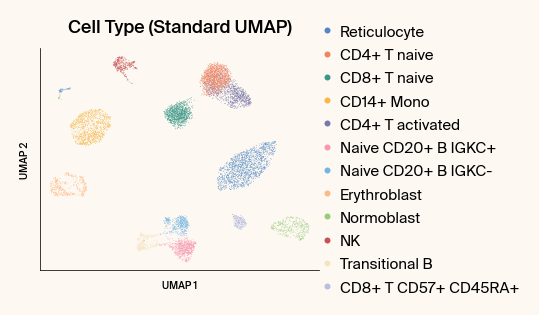

--- Plotting Parametric UMAP (Fit 0) ---


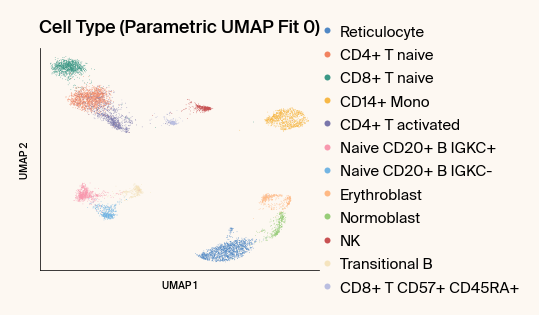

In [5]:
# | code-fold: true
# | label: fig-umap-original
# | layout-ncol: 1
# | fig-cap: "The conventional ScanPy UMAP and the PyTorch network UMAP. While they are not exactly the same, note the overall similarities. It is also possible to directly fit the embedding learned by the conventional UMAP algorithm, but here we show a fit with the PyTorch method to demonstrate how they find similar embeddings."
# | fig-subcap:
# |   - "The conventional ScanPy UMAP embedding."
# |   - "The PyTorch network UMAP embedding."

# Generate the standard Scanpy UMAP plot for comparison
pipeline.plot_scanpy_umap()

# Generate the plot for the last parametric UMAP fit (default)
pipeline.plot_parametric_umap(fit_index=0)

## Exact decomposition of features

The Jacobians are computed for each input over the independent fits. This takes a bit of time: about two minutes per fit on a T4 GPU (on the order of the time spent fitting the model).

In [6]:
%%time
if train:
    pipeline.compute_feature_contributions()

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 6.68 μs


We can validate that the Jacobian reconstructs the embedding network output.

--- Loading validation data from bmmc_features_plot_data.npz ---


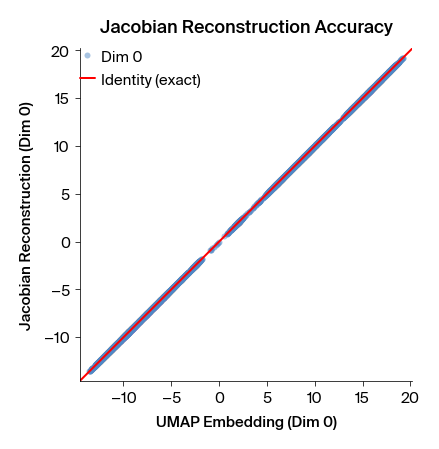

In [7]:
# | code-fold: true
# | label: fig-reconstruction-validation
# | fig-align: center
# | layout-ncol: 1
# | fig-cap: "To validate that the Jacobian reconstructs the UMAP encoder network output, we plot the embedding values against their Jacobian reconstructions and see that they fall on the identity line."

# Validate the Jacobian for the first model

if train:
    print("\n--- Validating Jacobian Reconstruction ---")
    pipeline.validate_jacobian(fit_index=0, summary_plot_file=None)#summary_plot_file='bmmc_features_plot_data.npz'
else:
    pipeline.validate_jacobian(fit_index=0, summary_plot_file='bmmc_features_plot_data.npz')


In [8]:
if train:
    pipeline.save_analysis_summary(basename="bmmc_features")

## PyTorch UMAP with Feature Labels

We can visualize the embedding and add the top gene contributors to the embedding position as information in the hovertip. 
As an alternative visualization, we can color the embedding by the largest gene contributor. In some cases, a given cell type label will have different regions where different genes make the largest contribution, like for Reticulocytes, which have several sub regions where the strongest contributors are HBD and HBA2, but the sub region with HBD as the largest gene contributor also extends to the neighboring Normoblast cluster. The UMAP embedding is placing these points near each other because the HBD activity is similar (and correlations with other features are distinctive).

In [9]:
# | code-fold: true
# | label: fig-umap-hover-top-genes
# | layout-ncol: 1
# | fig-cap: "The PyTorch UMAP embedding colored by cell type with top genes for each cell labeled in the hover tip."
#plotly UMAP embedding with data tags

if train:
    pipeline.plot_interactive(fit_index=0,summary_file=None)##summary_file="bmmc_features_interactive.csv")
else:
    pipeline.plot_interactive(fit_index=0, summary_file="bmmc_features_interactive.csv")

--- Loading interactive data from bmmc_features_interactive.csv ---


### Embedding labeled by top gene contributor

In [10]:
# | code-fold: true
# | label: fig-umap-plot-genes
# | layout-ncol: 1
# | fig-cap: "The PyTorch UMAP embedding colored by top geen feature, showing that some cell types have regions with different top gene contributors, and some top gene contributors extend across type divisons."
#plotly UMAP embedding colored by top gene features

if train:
    pipeline.plot_interactive(fit_index=0, summary_file=None,color_by='top_gene')#(summary_file="bmmc_features_interactive.csv", color_by='top_gene',show_centroids=True)
else:
    pipeline.plot_interactive(fit_index=0, summary_file="bmmc_features_interactive.csv", color_by='top_gene',show_centroids=True)

--- Loading interactive data from bmmc_features_interactive.csv ---


### Top gene features by cell type

We can also generate these plots on average over each class. With 8 separate UMAP fits at different random initializations, we provide the standard error of the normalized mean contribution of each feature. The feature contributions are normalized by the mean embedding distance of the class for a given fit, since in one fit a class could be class to the origin, and far away from the origin in another. 

Note that the largest feature contributors do not always point in the direction of the centroid. This gives rise to a gradient of contribution across a cluster. For example, in the reticulocyte cluster, cells embedded with a more negative UMAP 2 coordinate have higher contributions from HBD and HBM, while cells with a more negative UMAP 1 coordinate have higher HBA2, HBA1 and HBB contributions.

--- Loading data from bmmc_features_stats.csv and bmmc_features_plot_data.npz ---


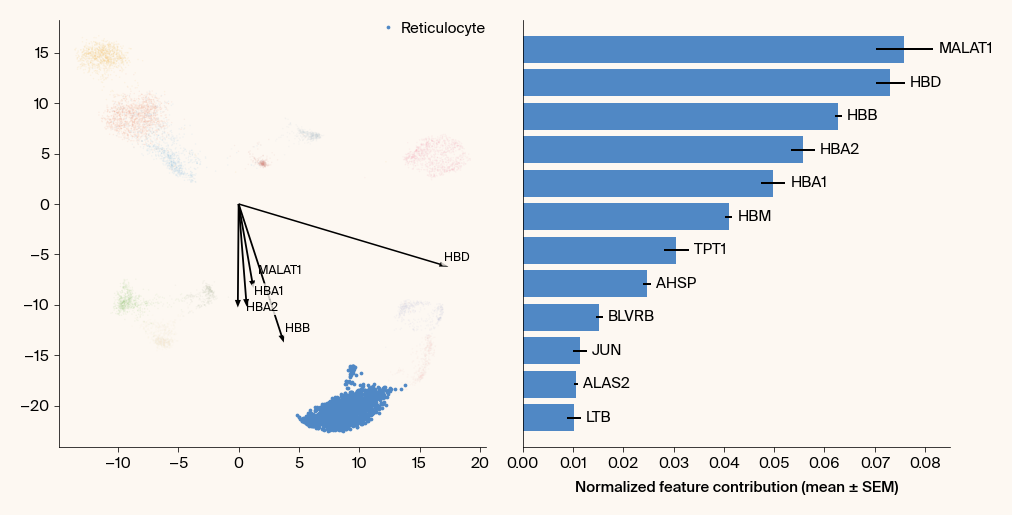

In [11]:
# | label: fig-top-gene-features-by-type-single
# | layout-ncol: 1
# |  "The top gene features for each cell type. Note that the largest feature vectors do not always point to the centroid, often indicating a gradient of importance for that feature across the cluster. Error bars are generated by normalizing the feature importance vectors for each cell by the distance to the centroid of the class for that UMAP fit to account for changing cluster centroids across fits."
if train:
    pipeline.plot_feature_importance_by_cell_type(
        fit_index=0,
        cell_type_plot=list(np.arange(1)), # Corresponds to the 3rd cell type in adata.obs["cell_type"].value_counts()
        summary_plot_file=None,#'bmmc_features_plot_data.npz',
        summary_stats_file=None,#'bmmc_features_stats.csv'
    )
else:
    pipeline.plot_feature_importance_by_cell_type(
        fit_index=0,
        cell_type_plot=list(np.arange(1)), # Corresponds to the 3rd cell type in adata.obs["cell_type"].value_counts()
        summary_plot_file='bmmc_features_plot_data.npz',
        summary_stats_file='bmmc_features_stats.csv'
    )
# summary_stats_file="analysis_summary_stats.csv",
# summary_plot_file="analysis_summary_plot_data.npz"

### Dot plots

We can compare the features found by the Jacobian to differential expression.

we find that many of the features found by differential expression between cell types are not preserved in the Jacobian representation. 
This highlights how the Jacobian method provides a complementary view of the feature space to features from differential expression.

--- Loading Jacobian stats from bmmc_features_stats.csv ---


--- Loading Jacobian magnitudes from bmmc_features_plot_data.npz ---


Adata and summary file genes match. Assigning layer directly.
--- Running differential expression analysis ---


--- Generating comparison dot plots ---


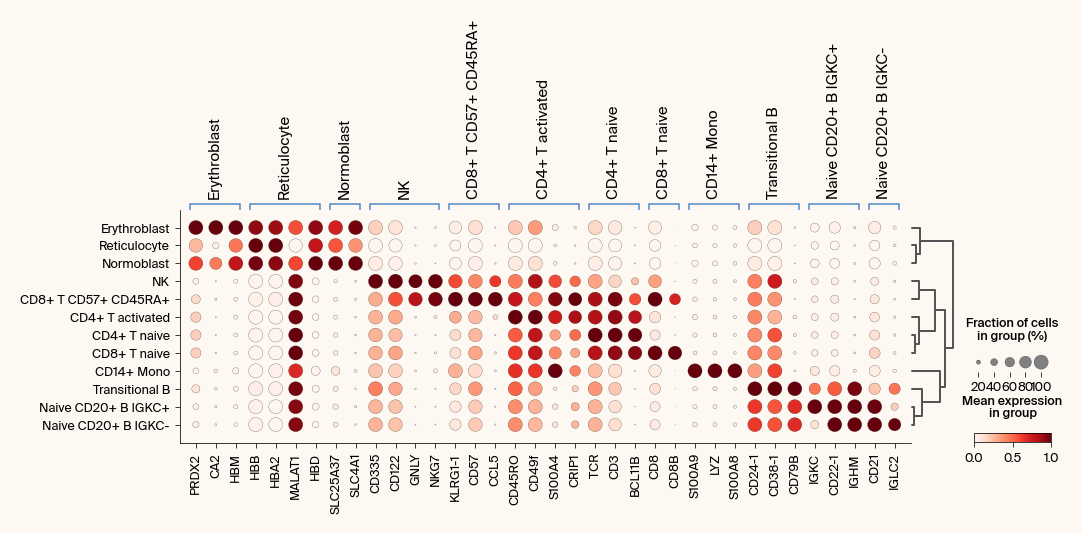

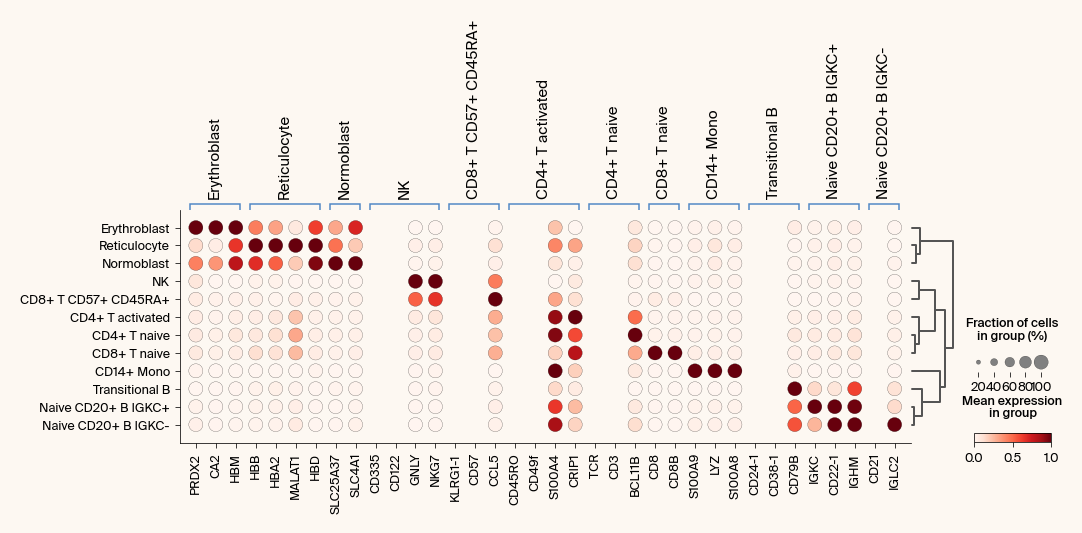

In [12]:
# | label: fig-dotplot
# | layout-ncol: 1
# | fig-cap: "Dot plots for gene expression analysis."
# | fig-subcap: 
#       - "The dot plot for the top differential expression features by cell type."
#       - "The dot plot for the top differential Jacobian features by cell type."
# 5. 🌟 NEW: Run the comparative analysis and generate dot plots
if train:
    pipeline.compare_with_differential_expression(n_top_genes=2, summary_stats_file=None, summary_plot_file=None)#'bmmc_features_stats.csv', summary_plot_file='bmmc_features_plot_data.npz',)
else:
    pipeline.compare_with_differential_expression(n_top_genes=2, summary_stats_file='bmmc_features_stats.csv', summary_plot_file='bmmc_features_plot_data.npz')
# Note: 'Jacobian feature importance' dot plot can only be shown when generated on-the-fly.

--- Loading data from bmmc_features_stats.csv and bmmc_features_plot_data.npz ---


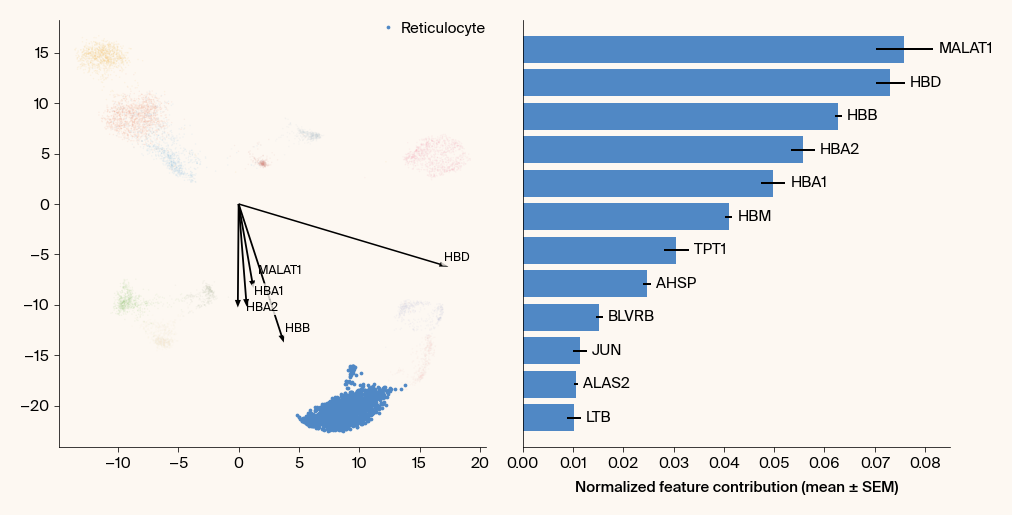

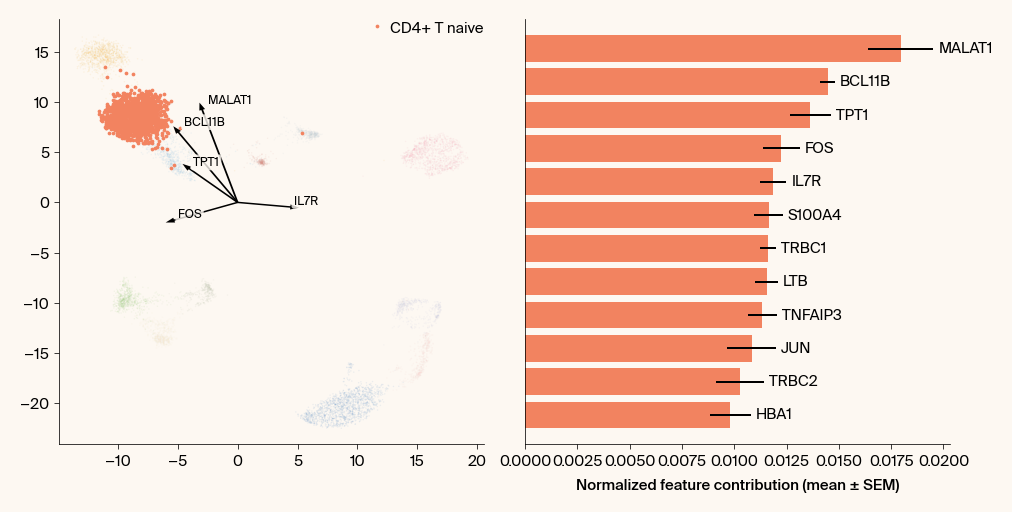

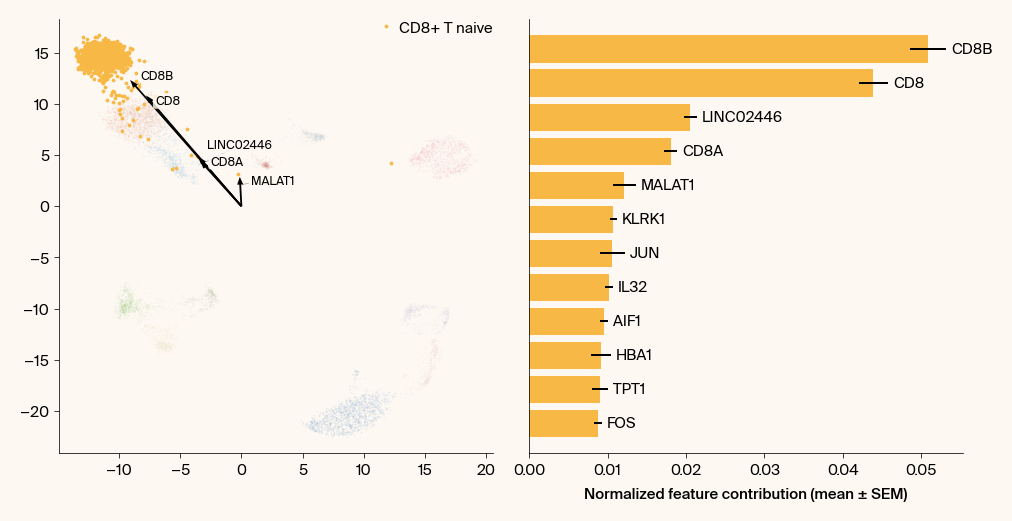

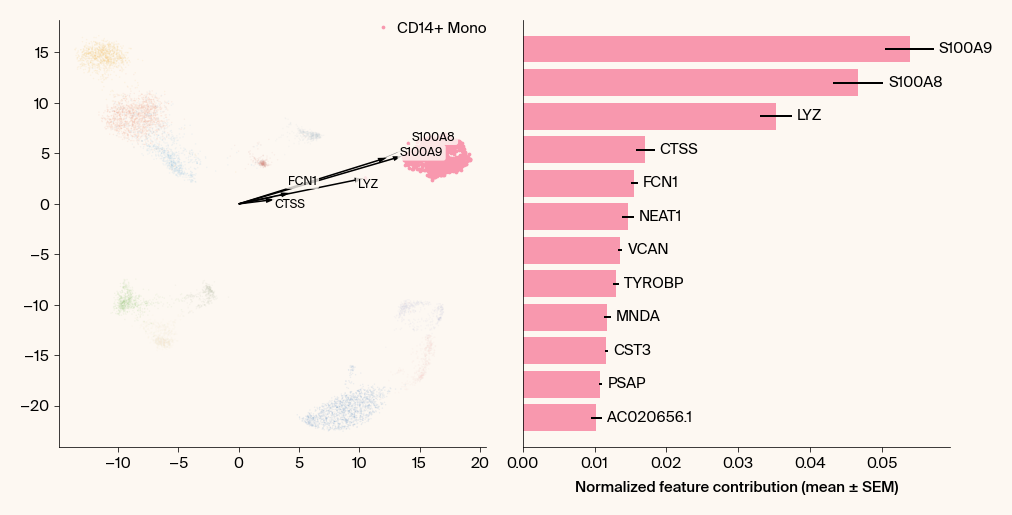

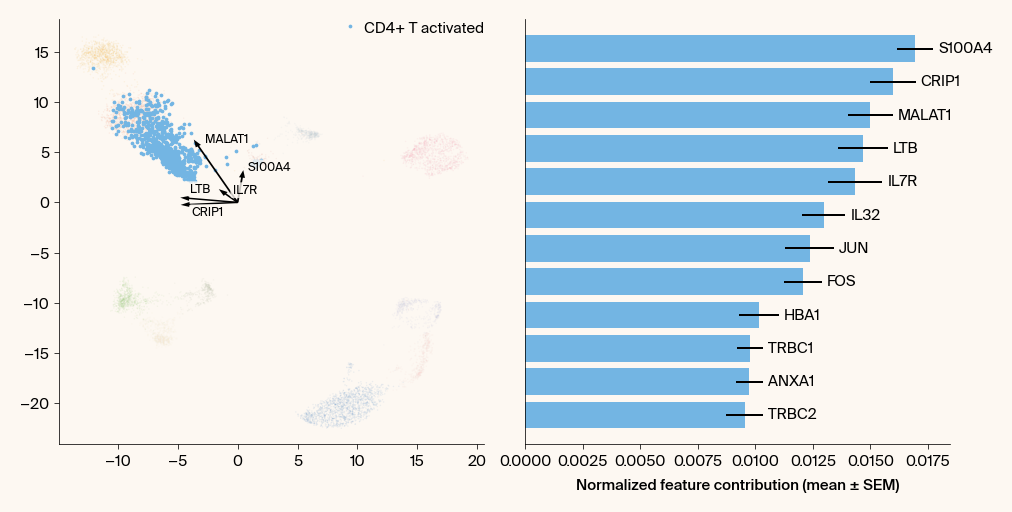

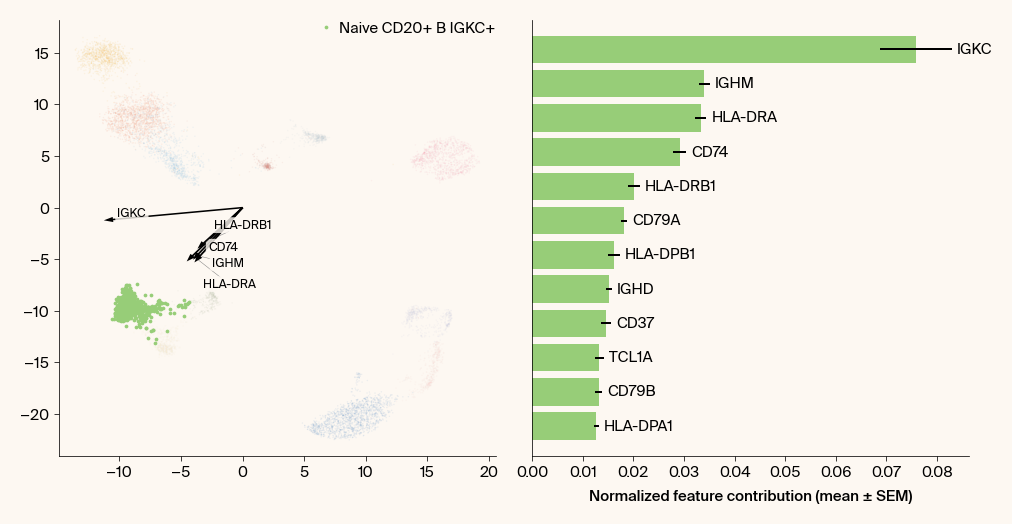

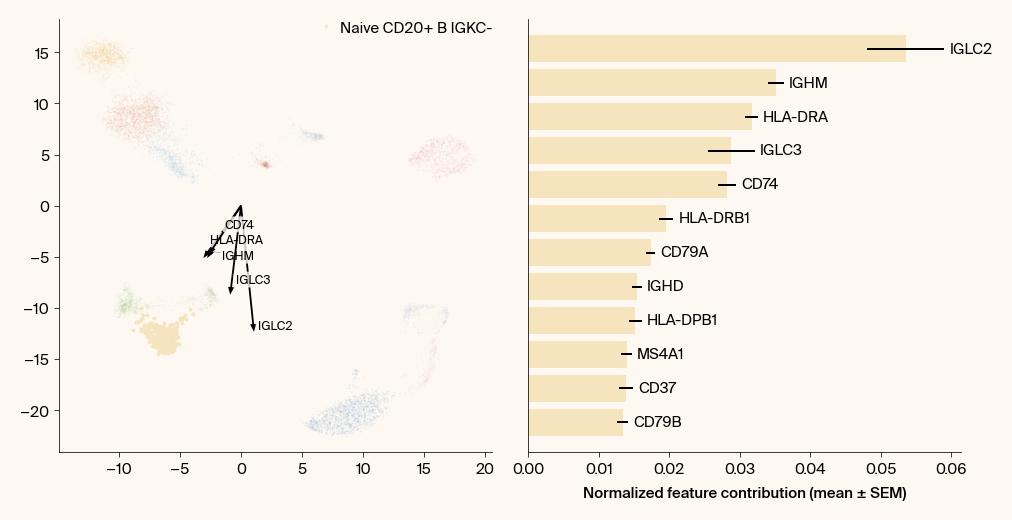

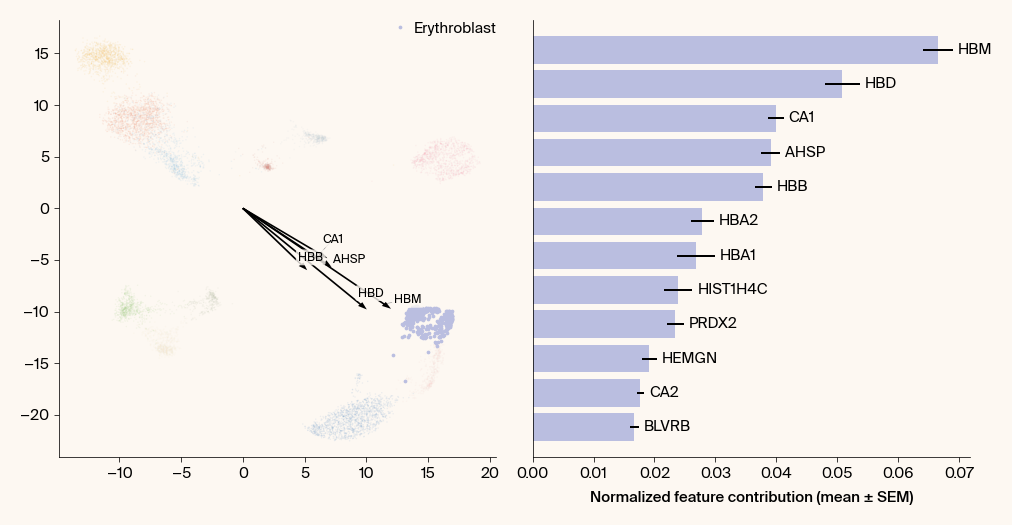

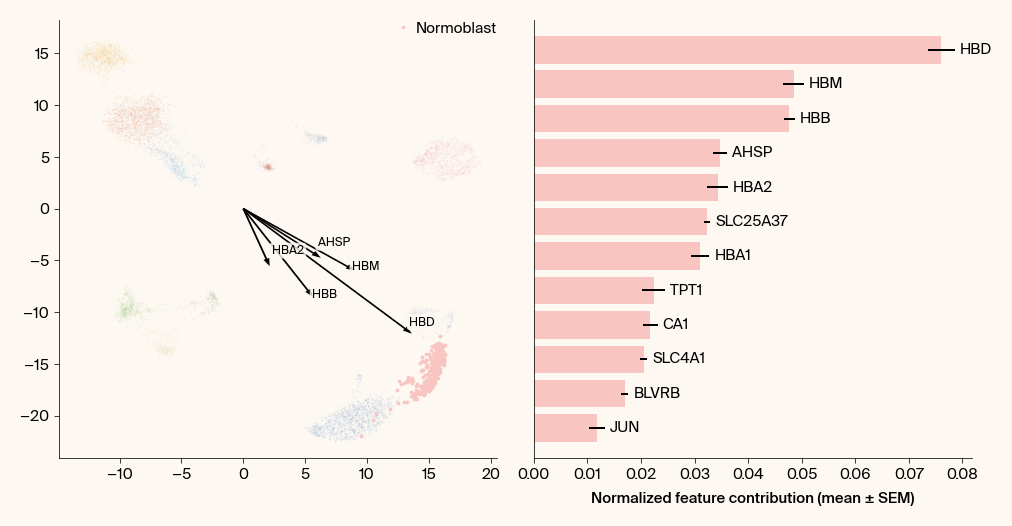

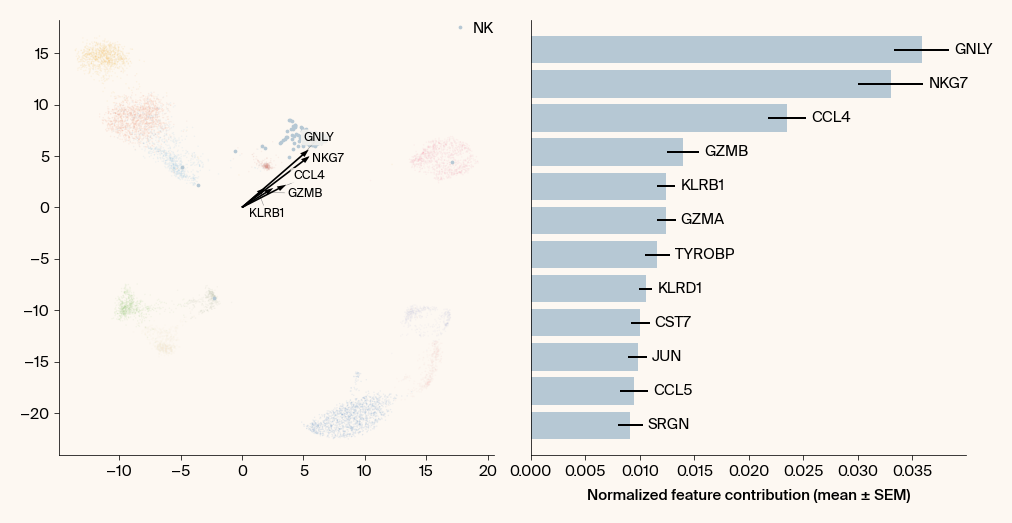

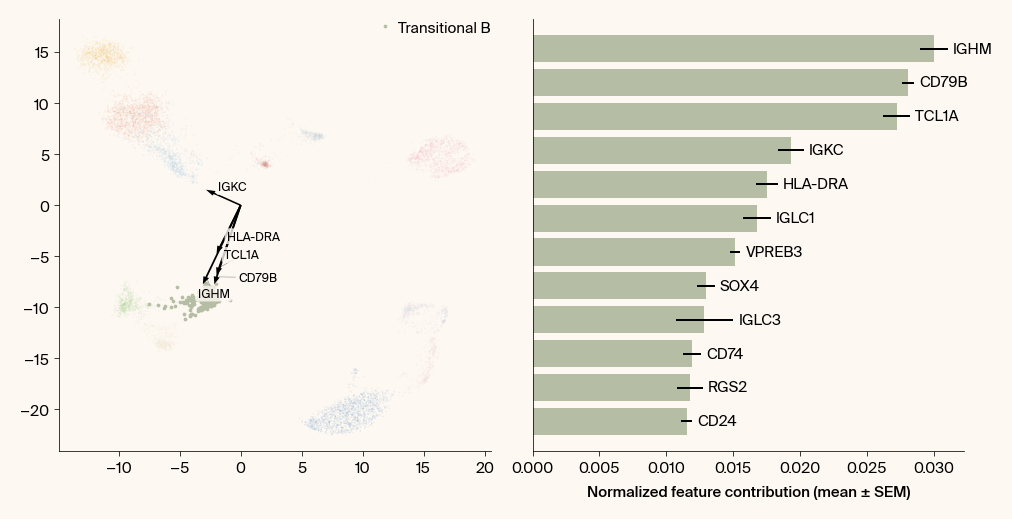

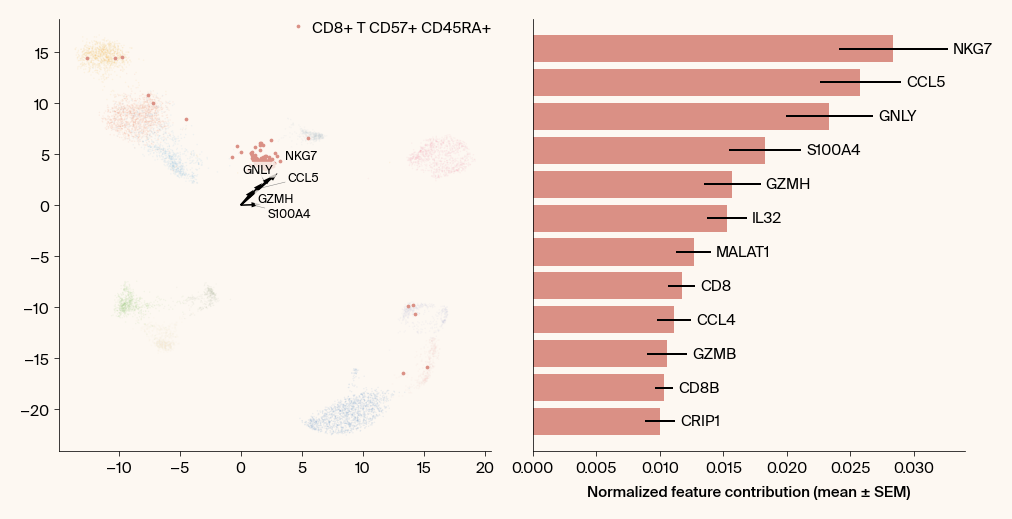

In [13]:
# | label: fig-top-gene-features-by-type-all
# | layout-ncol: 1
# | fig-cap: "The top gene features for each cell type. Note that the largest feature vectors do not always point to the centroid, often indicating a gradient of importance for that feature across the cluster. Error bars are generated by normalizing the feature importance vectors for each cell by the distance to the centroid of the class for that UMAP fit to account for changing cluster centroids across fits."
if train:
    pipeline.plot_feature_importance_by_cell_type(
        fit_index=0,
        cell_type_plot=list(np.arange(12)), # Corresponds to the 3rd cell type in adata.obs["cell_type"].value_counts()
        summary_plot_file=None,#'bmmc_features_plot_data.npz',
        summary_stats_file=None,#'bmmc_features_stats.csv'
    )
else:
    pipeline.plot_feature_importance_by_cell_type(
        fit_index=0,
        cell_type_plot=list(np.arange(12)), # Corresponds to the 3rd cell type in adata.obs["cell_type"].value_counts()
        summary_plot_file='bmmc_features_plot_data.npz',
        summary_stats_file='bmmc_features_stats.csv'
    )

## Conclusion

This work demonstrates a novel approach to interpreting UMAP embeddings by leveraging glass box deep networks. We've shown how to overcome the traditional black box nature of nonlinear dimensionality reduction, specifically UMAP, by implementing a locally linear (but globally nonlinear) embedding function. This allows for the exact quantification of feature attributions for each data point in the UMAP embedding space, directly quantifying the contribution of individual genes to cell positions for scRNAseq data. This stands in contrast to conventional methods like differential expression, which provide only a proxy for what UMAP has learned.

## References

Chari, T., & Pachter, L. (2023). The specious art of single-cell genomics. PLOS Computational Biology, 19(8), e1011288.

Luecken, M. D., Burkhardt, D. B., Cannoodt, R., Lance, C., Agrawal, A., Aliee, H., ... & Bloom, J. M. (2021, August). A sandbox for prediction and integration of DNA, RNA, and proteins in single cells. In Thirty-fifth conference on neural information processing systems datasets and benchmarks track (Round 2).

Mohan, S., Kadkhodaie, Z., Simoncelli, E. P., & Fernandez-Granda, C. (2019). Robust and interpretable blind image denoising via bias-free convolutional neural networks. arXiv preprint arXiv:1906.05478.

Wang, S., Mohamed, A. R., Caruana, R., Bilmes, J., Plilipose, M., Richardson, M., ... & Aslan, O. (2016, June). Analysis of deep neural networks with extended data jacobian matrix. In International Conference on Machine Learning (pp. 718-726). PMLR.
